In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib tk

In [2]:
import math
import numpy
import matplotlib.pyplot as plt
import sys
import os
from tabulate import tabulate

This notebook is used to process the L2 error data files for a given case and generate convergence tables and figures.

# Setup

In [3]:
# Different P Values to consider for the convergence study
CONST_P_VALUES = [1, 2, 3]

# The mesh levels for each P value (ith array corresponds to P[i])
CONST_ML_VALUES = [[1, 2, 3, 4, 5],
                   [1, 2, 3, 4, 5],
                   [1, 2, 3, 4, 5]]

# Directory with the error convergence data (in text files)
CONST_ERROR_FOLDER_PATH = "../../../build_2D/output/errors/euler/steady/NURBS/NURBSInternalPatch"

# The prefix for the error file names in the directory. That is, the files are listed
# in the directory as [CONST_TEST_CASE_PREFIX]__mlX__pY_0.txt where X and Y correspond
# to the mesh level and order
CONST_TEST_CASE_PREFIX = "l2_errors__TEST_Euler_NURBS_ParametricQUAD2D"

# The curve colors to be cycled through on each plot (plot the curves
# in order the same way for each plot so the curve colors are identical for each 
# P value for each plot.
CONST_CURVE_COLORS = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

# Directory where we would like to output the results
CONST_OUTPUT_PATH = "/Users/jm-034232/Documents/McGill/Research/Results/Internal_Channel_Error_Convergence/NURBSPatch"


## Functions and Classes for Processing
Classes and functions used for processing the error data from the text files.

In [4]:

class TestCaseP(object):

    """
    Holds the data related to the given test case. All mesh level
    data for a given P value will be stored in this class
    """

    def __init__(self, P):

        """
        Initializes the TestCaseP class with the P value

        :param P: The order of test case
        """

        self.P = P

        # Holds the data for each mesh level as a dictionary
        # of the form {h: value, s: value, s_theo: value}. Data stored in order from 
        # smallest to largest mesh level (but ordering won't matter since the data 
        # will be sorted according to mesh length (h)). 
        self.results = []


    def add_experimental_results(self, abs_file_path):

        """
        Add the experimental results in the given file to the experimental_results
        array

        :param abs_file_path: The absolute path to the file with the data to read. 
            This should be the *_p.txt file

        :return: -
        """

        with open(abs_file_path, "r") as fp:

            # Process the error file. Find which column holds the h and s data
            # and load it

            # Ignore the first 3 lines of the error file
            for i in range(3):
                fp.readline()

            header_line = fp.readline().rstrip("\n")
            header_line_vals = header_line.split()

            h_data_index = -1
            s_data_index = -1

            for column_title in header_line_vals:
                if column_title == "h":
                    h_data_index = header_line_vals.index(column_title)
                elif column_title == "$s$":
                    s_data_index = header_line_vals.index(column_title)

            if h_data_index < 0 or s_data_index < 0:
                raise ValueError("h or s data not found in error file : %s " % abs_file_path)

            data_line = fp.readline().rstrip("\n")
            data_line_vals = [float(x) for x in data_line.split()] 

            h_value = data_line_vals[h_data_index]
            s_value = data_line_vals[s_data_index]

            self.results.append({"s": s_value, "h": h_value})


    def compute_theoertical_results(self):

        """
        Compute what the theoretical values for the convergence should be at each
        mesh level and store this data in a s_theo key in the results list
        """

        theoretical_conv_rate = self.P + 1

        # Sort according to mesh length
        self.results = sorted(self.results, key=lambda x: x['h'])

        ln_h_min = math.log(self.results[0]['h'])
        ln_s_min = math.log(self.results[0]['s'])
        self.results[0]['s_theo'] = math.exp(ln_s_min) # For h_min s_theo is the same as s

        # Compute the s_theo values
        for i in range(1, len(self.results)):

            ln_h_val = math.log(self.results[i]['h'])
            ln_s_val = math.log(self.results[i]['s'])

            ln_s_theo = theoretical_conv_rate*(ln_h_val - ln_h_min) + ln_s_min

            self.results[i]['s_theo'] = math.exp(ln_s_theo)


    def plot_error_values(self, var_key, var_theo_key, curve_color):

        """
        On the global plt object plot the curve for the error convergence for the
        given variable

        :param var_key: The key (string) for the variable whose error to plot
        :param var_theo_key: The key (string) for the variable's theoertical value
        :param curve_color: The color of the curve and theoretical curve
        """

        x_vals = []
        y_vals = []
        y_vals_theo = []

        for data_val in self.results:

            x_vals.append(data_val['h'])
            y_vals.append(data_val[var_key])
            y_vals_theo.append(data_val[var_theo_key])

        curve_label = "P : " + str(self.P)

        plt.plot(x_vals, y_vals, c=curve_color, label=curve_label)
        plt.scatter(x_vals, y_vals, c=curve_color)
        plt.plot(x_vals, y_vals_theo, c=curve_color, linestyle="--")


In [5]:

def load_error_data():

    """
    Load the error data from the error files in the provided directory

    :return: A list of TestCaseP objects holding the data for the error data
        for each P and their associated mesh levels
    """

    TestCaseP_list = []

    for P in CONST_P_VALUES:
        # loop over all the P values
        TestCaseP_object = TestCaseP(P)

        for ml in CONST_ML_VALUES[CONST_P_VALUES.index(P)]:
            # loop over all the mesh levels

            error_file_name = CONST_TEST_CASE_PREFIX + "__ml" + str(ml) + "__p" + str(P) + "_p.txt"
            error_file_abs_path = os.path.join(CONST_ERROR_FOLDER_PATH, error_file_name)

            # load the error data
            TestCaseP_object.add_experimental_results(error_file_abs_path)

        # Get the theoretical error values now
        TestCaseP_object.compute_theoertical_results()
        TestCaseP_list.append(TestCaseP_object)

    return TestCaseP_list


# Load Data and Process

In [6]:
TestCaseP_list = load_error_data()

# Visualize Results
Output tables and figures showing the convergence results

In [7]:

def get_output_table(TestCaseP_list):

    """
    Output the convergence results in tabular format 

    :param TestCaseP_list: The list of test case P objects
    """

    results_table = []

    # Header line
    results_table.append(["Polynomial", "h", "L2 Entropy Error", "Conv. Order"])

    for TestCaseP_obj in TestCaseP_list:

        test_case_error_data_table = []

        # Get the table of error values
        for data_val in TestCaseP_obj.results:

            test_case_error_data_table.append([
                data_val['h'],
                data_val['s'],
                "-"
                ])

        # reverse the order of the data with respect to the h (smallest h last)
        test_case_error_data_table = sorted(test_case_error_data_table, reverse=True, key=lambda x: x[0])

        # Compute the convergence orders
        for i in range(1, len(test_case_error_data_table)):

            s2 = test_case_error_data_table[i][1]
            s1 = test_case_error_data_table[i-1][1]

            h2 = test_case_error_data_table[i][0]
            h1 = test_case_error_data_table[i-1][0]

            conv_order = math.log(s2/s1)/ math.log(h2/h1)

            test_case_error_data_table[i][2] = conv_order


        # Add the rows to the table
        for i in range(len(test_case_error_data_table)):

            new_row = []
            if i == 0:
                new_row.append("P = %d " % TestCaseP_obj.P)
            else:
                new_row.append(" ")

            for val in test_case_error_data_table[i]:
                new_row.append(val)

            results_table.append(new_row)

        # Add an empty row between each P
        results_table.append([" ", " ", " ", " "])

    return tabulate(results_table)
    

In [8]:

table_str = get_output_table(TestCaseP_list)
print(table_str)

# Output the table information to a file
convergence_table_file = "convergence_table.txt"
convergence_table_file_abs_path = os.path.join(CONST_OUTPUT_PATH, convergence_table_file)

with open(convergence_table_file_abs_path, "w") as fp:
    fp.write(table_str)



----------  ---------  --------------------  ------------------
Polynomial  h          L2 Entropy Error      Conv. Order
P = 1       0.125      0.0024119770692626    -
            0.0625     0.000206182461644577  3.548222667486476
            0.03125    4.61067717231048e-05  2.1608710583359994
            0.015625   9.19384039573387e-06  2.3262391290861224
            0.0078125  1.74081766219132e-06  2.400902522073096

P = 2       0.083333   0.000211147916963194  -
            0.041667   1.77269686871476e-05  3.574298132448049
            0.020833   2.07750642707496e-06  3.0929139194840545
            0.010417   2.61922379221245e-07  2.987848608059753
            0.0052083  2.89243988906087e-08  3.1786043586289434

P = 3       0.0625     4.47698293204892e-05  -
            0.03125    1.42022603451482e-06  4.978334354492063
            0.015625   1.10105330210972e-07  3.689164341819646
            0.0078125  7.46027451256745e-09  3.8835117836941375
            0.0039062  4.3407056795271

In [9]:

def plot_error_convergence(TestCaseP_list):

    """
    Plot the error convergence for the required variables

    :param TestCaseP_list: The list of test case objects
    """

    # Create the entropy error plot
    for TestCaseP_obj in TestCaseP_list:

        curve_color = CONST_CURVE_COLORS[TestCaseP_list.index(TestCaseP_obj)]
        TestCaseP_obj.plot_error_values("s", "s_theo", curve_color)

    plt.gca().set_yscale('log')
    plt.gca().set_xscale('log')

    plt.title("Entropy Error Convergence (NURBS Enhanced Case)")
    plt.ylabel("Entropy Error")
    plt.xlabel("h")

    plt.legend()
    plt.grid()
    

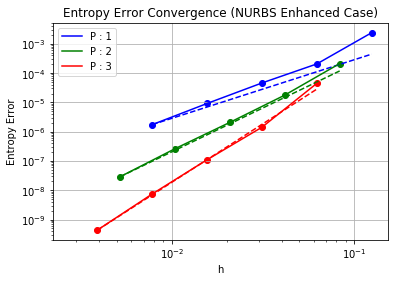

In [10]:

plot_error_convergence(TestCaseP_list)

# Save the figure
convergence_plot_file = "convergence_plot.pdf"
convergence_plot_file_abs_path = os.path.join(CONST_OUTPUT_PATH, convergence_plot_file)
plt.savefig(convergence_plot_file_abs_path)
